In [1]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
import sys
sys.path.append('../../')
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython
from dataset import Dataset

/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-06 21:04:43.506366: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-06 21:04:43.516398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 21:04:43.527340: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024

In [2]:
data = Dataset('4h')
data = data.preprocess()

/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if

In [4]:
data

,Timestamp,Real Energy,diff,Product Group,SKU code,Event Code_plc,Duration (sec),Καθαρές Μηχανοώρες (min),Work Center,Event Code_mes,...,DB 2000DBW 56 man counter,DB 700DBW 46 contener counter,DB 301DBW 272 cooling water mandrel outlet,DB 301DBW 274 cooling water mandrel inlet,DB 301DBW 276 mandrel coolng flow,DB 301DBW 96 mandrell movment,DB 30DBW 80 contener position,DB 10DBW 114 cont cooling air flow,MW 46 mikos bigetas,DB 301DBW 166 mikos solinas
0,2022-05-01 08:00:00,1.296980e+08,960.405,{DB3},{1.0},"{99.0, 901.0, 98.0}",2623.0,34.216667,"{S_DAN2, S_DAN1, S_SCH4B}","{99.0, 70.0, 0.0}",...,544.554743,2066.553884,64.473058,58.571367,163.411938,63.492118,13.894239,431.795357,816.170536,307.558255
1,2022-05-01 12:00:00,5.188397e+08,4721.408,{DB3},{1.0},"{99.0, 0.0, 901.0, 98.0}",14669.0,192.916667,"{S_DAN2, S_DAN1, S_SCH4B}","{99.0, 70.0}",...,544.554743,2066.553884,64.473058,58.571367,163.411938,63.492118,13.894239,431.795357,816.170536,307.558255
2,2022-05-01 16:00:00,5.189115e+08,4373.916,{DB3},{1.0},"{99.0, 0.0, 98.0, 702.0}",14366.0,172.883333,"{S_DAN2, S_DAN1, S_SCH4B}","{99.0, 70.0}",...,600.988510,2122.988069,58.686782,56.058016,126.138477,60.589637,21.618503,339.543426,815.726949,312.024554
3,2022-05-01 20:00:00,5.189749e+08,2823.071,{DB3},{1.0},"{0.0, 98.0, 99.0, 701.0, 611.0}",11094.0,96.633333,"{S_DAN2, S_DAN1, S_SCH4B}","{99.0, 70.0, 0.0}",...,639.012936,2161.012326,52.120623,51.342161,94.952455,62.909177,111.900576,224.601084,814.096647,307.937216
4,2022-05-02 00:00:00,5.189935e+08,381.473,{DB3},{1.0},"{0.0, 98.0, 99.0, 701.0, 611.0}",11094.0,96.633333,"{S_DAN2, S_DAN1, S_SCH4B}","{99.0, 70.0, 7.0}",...,652.000000,2174.000000,30.415710,36.528370,3.000000,73.000000,484.000000,11.890784,813.000000,306.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,2022-07-30 16:00:00,5.465586e+08,3456.885,{DB3},{1.0},"{0.0, 98.0, 702.0, 99.0, 701.0}",10863.0,109.333333,"{S_DAN2, S_DAN1, S_SCH4B}","{99.0, 70.0}",...,747.135024,20689.531376,69.370134,64.580993,116.274144,82.638641,40.293608,400.921240,815.911508,309.483514
543,2022-07-30 20:00:00,5.465841e+08,476.019,{DB3},{1.0},{1102.0},14400.0,109.333333,"{S_DAN2, S_DAN1, S_SCH4B}","{99.0, 70.0}",...,747.135024,20729.000000,42.679245,44.277628,116.274144,76.000000,991.000000,0.119272,819.000000,305.000000
544,2022-07-31 00:00:00,5.465929e+08,919.244,{DB3},{1.0},"{0.0, 98.0, 1102.0}",17909.0,109.333333,"{S_DAN2, S_DAN1, S_SCH4B}","{99.0, 70.0}",...,0.462562,20729.462336,41.374605,41.555706,36.700947,85.432341,415.624944,2.449030,817.194181,305.741092
545,2022-07-31 04:00:00,5.466415e+08,4567.031,{DB3},{1.0},"{901.0, 0.0, 710.0, 98.0, 99.0}",12435.0,129.466667,"{S_DAN2, S_DAN1, S_SCH4B}","{99.0, 70.0, 0.0}",...,65.851867,20794.850217,68.465924,61.887874,131.088067,94.469022,14.924042,429.154369,815.015328,305.225016


In [9]:
# data = Dataset('1h')
# data = data.preprocess()
data = pd.read_csv("/home/stelios-pc/Desktop/PhD/HALCOR/temp.csv")
data.drop(columns=['Unnamed: 0','Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])

# Numerical data
scaler = MinMaxScaler() #scaler
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
# data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])
print(data)
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
numerical_data = scaler.fit_transform(data)

# Forming the sequences for both categorical and numerical data
n_future = 1   # Number of 15-min we want to look into the future based on the past (Out).
n_past = 6   # Number of past 15-min we want to use to predict the future (Step). Basically 4-hours
features = len(cols) - 1  # Number of features

def split_sequence(seq, steps, out):
    X, Y = list(), list()
    for i in range(len(seq)):
        end = i + steps
        outi = end + out
        if outi > len(seq)-1:
            break
        seqx, seqy = seq[i:end, 1:], seq[end:outi, 0] # 1 the column number I want to make the prediction
        X.append(seqx)
        Y.append(seqy)
    return np.array(X), np.array(Y)

X_num, Y_num = split_sequence(numerical_data, n_past, n_future) # numerical sequences

# in order to align cat-num, I need to append the target feature to the categorical features
categorical_data.insert(0, 'Energy', numerical_data[:, 0].reshape(-1, 1)) #energy column scaled like the numerical process
categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data)[1:], dtype=np.int64)
X_cat, Y_cat = split_sequence(categorical_data.to_numpy(), n_past, n_future) # categorical sequences
Y_cat = Y_cat.astype(np.float64)
X = np.concatenate((X_cat, X_num), axis=-1)

print(X_cat.shape, X_num.shape, Y_num.shape)


# Train/test splitting
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, Y_num, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle= False)
X_train, Y_train = X_train_temp, y_train_temp
print("Train sizes:")
print(X_train.shape,Y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)
del data, categorical_data, numerical_data

       Energy  Duration (sec)  Καθαρές Μηχανοώρες (min)  \
0     960.405          2623.0                 34.216667   
1    4721.408         14669.0                192.916667   
2    4373.916         14366.0                172.883333   
3    2823.071         11094.0                 96.633333   
4     381.473         11094.0                 96.633333   
..        ...             ...                       ...   
542  3456.885         10863.0                109.333333   
543   476.019         14400.0                109.333333   
544   919.244         17909.0                109.333333   
545  4567.031         12435.0                129.466667   
546  3078.674         12695.0                156.750000   

     Production Quantity (#)  DB  955DBW    8   in die side  \
0                       50.0                     500.979364   
1                      354.0                     500.979364   
2                      253.0                     479.491076   
3                      292.0           

In [10]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
from scikeras.wrappers import KerasRegressor
import sys
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython


class LearningRateLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        current_lr = float(keras.backend.get_value(lr))
        print(f"\nEpoch {epoch+1}: Learning rate is {current_lr}")

lr_schedule = ExponentialDecay(
    0.0001, decay_steps=100, decay_rate=0.96, staircase=True
)

def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.3, input_shape=(X_train.shape[1], X_train.shape[2]))))
    model.add(Bidirectional(LSTM(256 *2, activation='relu', return_sequences=True, dropout= 0.2, recurrent_dropout= 0.1)))
    # model.add(Bidirectional(LSTM(256 *4, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.1)))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(Dropout(0.1))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(n_future))
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mape'])
    return model

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './models/model-4-hour(4h).keras',        # Path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only the best model
    mode='min',             # Save when the quantity monitored has stopped decreasing
    verbose=1               # Verbosity mode
)
model = create_model()
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=2, callbacks=[checkpoint_callback, LearningRateLogger()], verbose=1, shuffle=False)

Epoch 1/20


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1365 - mae: 0.2909 - mape: 1106111.2500
Epoch 1: val_loss improved from inf to 0.08086, saving model to ./models/model-4-hour(4h).keras

Epoch 1: Learning rate is 9.215999307343736e-05
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1364 - mae: 0.2908 - mape: 1106455.8750 - val_loss: 0.0809 - val_mae: 0.2342 - val_mape: 148.3364
Epoch 2/20
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0946 - mae: 0.2581 - mape: 1168439.0000
Epoch 2: val_loss improved from 0.08086 to 0.07569, saving model to ./models/model-4-hour(4h).keras

Epoch 2: Learning rate is 8.49346470204182e-05
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0945 - mae: 0.2579 - mape: 1169552.3750 - val_loss: 0.0757 - val_mae: 0.2345 - val_mape: 137.1253
Epoch 3/20
221/230 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0877 - mae: 0.2474 - mape: 1123305.5000
Epoch 3: val_loss improved from 0.07569 to 0.07518, saving model to ./models/model-4-hour(4h).keras

Epoch 3: L

In [14]:
from keras.models import load_model
# load model

model = load_model('./models/model-4-hour(4h).keras')
predictions = model.predict(X_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x72df651211c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


In [43]:
predictions.shape

(41, 1)

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

zeros = np.zeros((X_test.shape[0], 35))
for i in range(zeros.shape[0]):
    zeros[i][0] = predictions[i]


predictions = scaler.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((X_test.shape[0],35))
for i in range(zeros.shape[0]):
    zeros[i][0] = Y_test[i]
original = scaler.inverse_transform(zeros)
original = [i[0] for i in original]

# Calculate metrics
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    :param y_true: Actual values.
    :param y_pred: Predicted values.
    :return: MAPE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(original, predictions)
mse = mean_squared_error(original, predictions)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(original, predictions)
median_ae = median_absolute_error(original, predictions)
mape = mean_absolute_percentage_error(original, predictions)


n = len(original)
p = X_test.shape[1] 
adjusted_r2_value = adjusted_r2(r2, n, p)
# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")
print(f"Median Absolute Error: {median_ae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape} %")

Mean Absolute Error (MAE): 1242.4355333020628
Mean Squared Error (MSE): 2008131.029813069
Root Mean Squared Error (RMSE): 1417.085399618904
R² Score: 0.27309110241681356
Adjusted R² Score: 0.1448130616668395
Median Absolute Error: 1185.8089225358553
Mean Absolute Percentage Error (MAPE): 147.6179789213668 %


/tmp/ipykernel_113159/3235171957.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = predictions[i]
/tmp/ipykernel_113159/3235171957.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = Y_test[i]


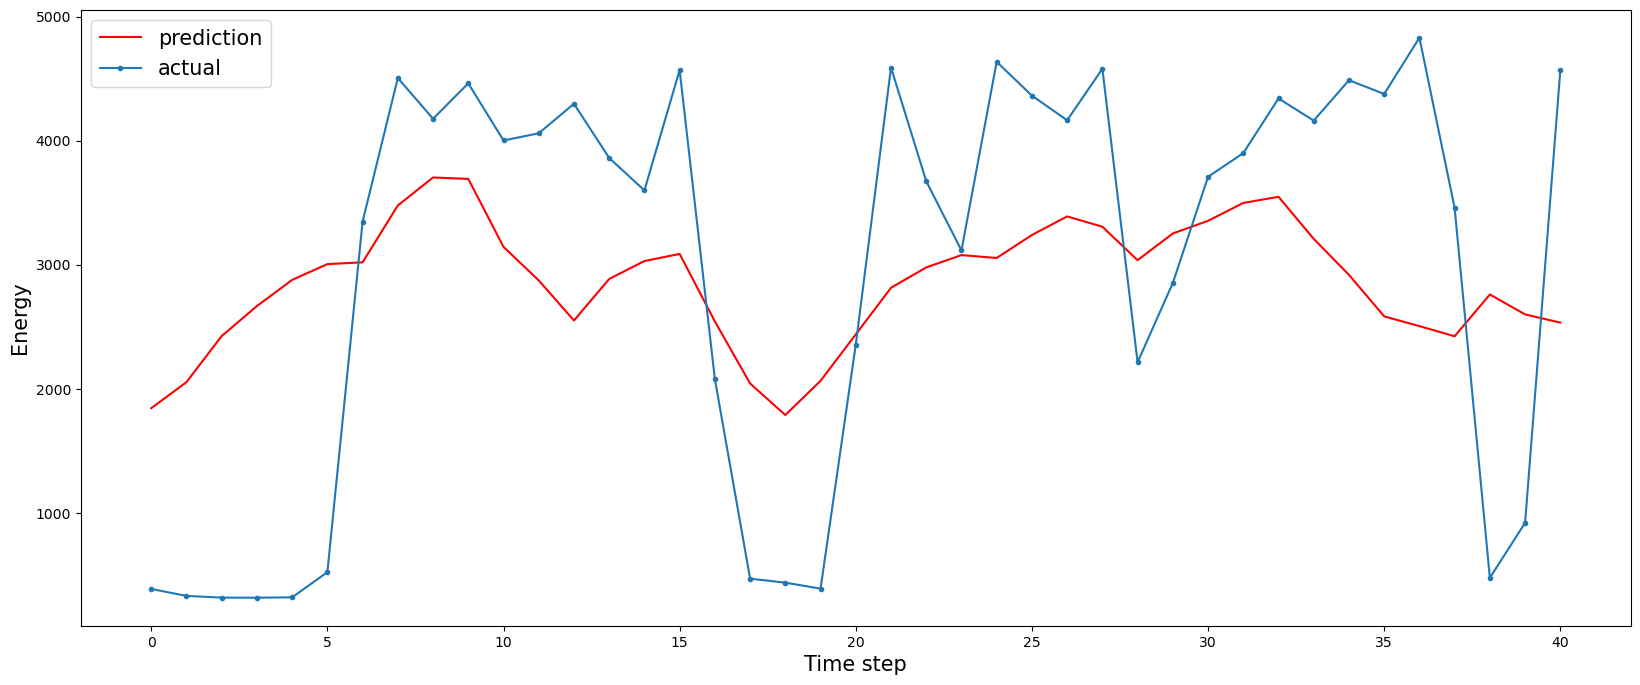

In [16]:
pyplot.figure(figsize=(20,8))
pyplot.plot(predictions, label='prediction', color="r")
pyplot.plot(original, label='actual', marker='.')
pyplot.legend()
pyplot.ylabel('Energy', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)

# wandb.log({"True_vs_Predicted": pyplot})
pyplot.show()

# Trying XGBoost for the coarser intervals

In [17]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler


In [18]:
# data = Dataset('4h')
# data = data.preprocess()
data = pd.read_csv('/home/stelios-pc/Desktop/PhD/HALCOR/Data/data.csv')
# data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# start_time = pd.Timestamp('2022-05-31 07:00:00')
# end_time = pd.Timestamp('2022-06-01 07:30:00')
# data = data[~((data['Timestamp'] >= start_time) & (data['Timestamp'] <= end_time))]
# start_time = pd.Timestamp('2022-05-31 08:00:00')
# end_time = pd.Timestamp('2022-06-01 09:00:00')
# data = data[~((data['Timestamp'] >= start_time) & (data['Timestamp'] <= end_time))]
# data.to_csv('/home/stelios-pc/Desktop/PhD/HALCOR/temp.csv')
data.drop(columns=['Unnamed: 0', 'Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

In [19]:
# Assuming your data is in a pandas DataFrame df with 'target' column to predict
data['lag_1'] = data['Energy'].shift(1)
data['lag_2'] = data['Energy'].shift(2)
data['lag_3'] = data['Energy'].shift(3)
data['lag_4'] = data['Energy'].shift(4)

# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])
categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)

data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
# data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])

scaler = StandardScaler()
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
scaled_numerical = scaler.fit_transform(data)
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns = data.columns)
X_combined = pd.concat([scaled_numerical_df, categorical_data], axis=1)


y = X_combined['Energy'] 
X_combined.drop(columns = 'Energy', inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle= False)
print("Train sizes:")
print(X_train.shape,y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)


train_data = xgb.DMatrix(X_train, label=y_train)
val_data = xgb.DMatrix(X_val, label=Y_val)
test_data = xgb.DMatrix(X_test, label=Y_test)
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'learning_rate': 0.0001,  # Small learning rate to avoid overfitting
    'max_depth': 5,         # Controls the complexity of the model (higher values may overfit)
    'n_estimators': 10000,    # Number of boosting rounds (you can tune this)
    'early_stopping_rounds': 50,  # Stop if there's no improvement after 50 rounds
    'alpha' : 0.1,
    'lambda' : 0.1,
}
# Use a validation set to avoid overfitting
evals = [(train_data, 'train'), (val_data, 'eval')]

# Train the XGBoost model
model = xgb.train(params, train_data, num_boost_round=10000, evals=evals, early_stopping_rounds=50, verbose_eval=100)
y_pred = model.predict(test_data)
# Calculate metrics



3153.0979862889067
4914.042999997735
140.12849999964237
Train sizes:
(464, 439) (464,)
Validation sizes:
(41, 439) (41,)
Test sizes:
(42, 439) (42,)
[0]	train-rmse:0.98247	eval-rmse:1.01717


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:11:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722516643542/work/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:0.97385	eval-rmse:1.00913
[200]	train-rmse:0.96532	eval-rmse:1.00118
[300]	train-rmse:0.95676	eval-rmse:0.99314
[400]	train-rmse:0.94828	eval-rmse:0.98519
[500]	train-rmse:0.93991	eval-rmse:0.97738
[600]	train-rmse:0.93166	eval-rmse:0.96994
[700]	train-rmse:0.92350	eval-rmse:0.96247
[800]	train-rmse:0.91543	eval-rmse:0.95511
[900]	train-rmse:0.90744	eval-rmse:0.94785
[1000]	train-rmse:0.89954	eval-rmse:0.94067
[1100]	train-rmse:0.89172	eval-rmse:0.93358
[1200]	train-rmse:0.88397	eval-rmse:0.92658
[1300]	train-rmse:0.87631	eval-rmse:0.91964
[1400]	train-rmse:0.86873	eval-rmse:0.91280
[1500]	train-rmse:0.86123	eval-rmse:0.90606
[1600]	train-rmse:0.85382	eval-rmse:0.89949
[1700]	train-rmse:0.84649	eval-rmse:0.89316
[1800]	train-rmse:0.83924	eval-rmse:0.88692
[1900]	train-rmse:0.83207	eval-rmse:0.88075
[2000]	train-rmse:0.82498	eval-rmse:0.87466
[2100]	train-rmse:0.81796	eval-rmse:0.86862
[2200]	train-rmse:0.81100	eval-rmse:0.86267
[2300]	train-rmse:0.80411	eval-rmse:0.856

In [20]:
# descale
test_data_len = test_data.get_data()
zeros = np.zeros((test_data_len.shape[0], 39))
for i in range(zeros.shape[0]):
    zeros[i][0] = y_pred[i]

predictions = scaler.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((test_data_len.shape[0],39))
for i in range(zeros.shape[0]):
    zeros[i][0] = y_test.iloc[i]
    
original = scaler.inverse_transform(zeros)
original = [i[0] for i in original]

mae = mean_absolute_error(original, predictions)
rmse = np.sqrt(mean_squared_error(original, predictions))
r2 = r2_score(original, predictions)
n = len(original)
p = test_data_len.shape[1]
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))
adjusted_r2_value = adjusted_r2(r2, n, p)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean squared error (MSE): {mean_squared_error(original, predictions)}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")

Mean Absolute Error (MAE): 922.3456662463965
Root Mean Squared Error (RMSE): 1227.8662031398762
Mean squared error (MSE): 1507655.412813136
R² Score: 0.31089793768608154
Adjusted R² Score: 1.0709879008916348


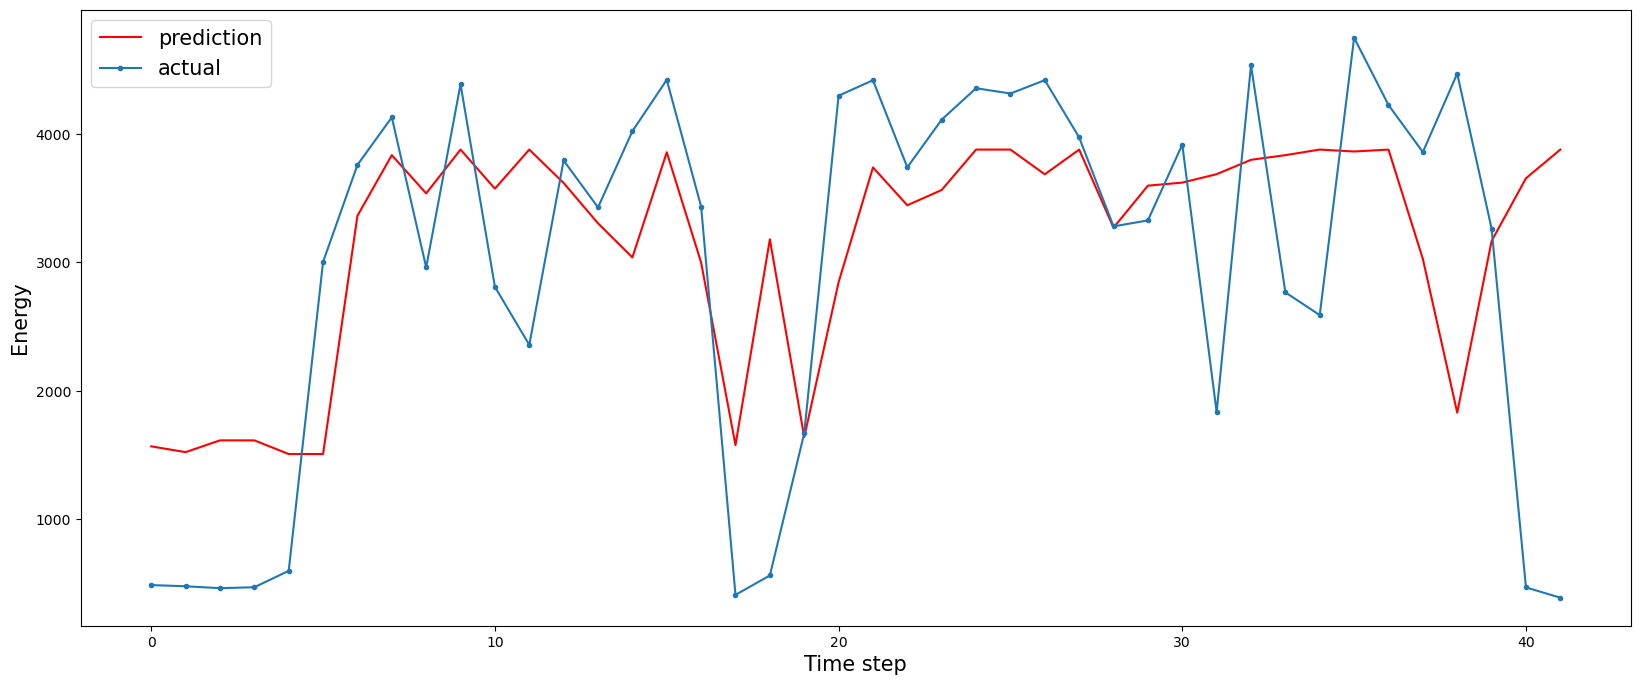

In [21]:
plt.figure(figsize=(20,8))
plt.plot(predictions, label='prediction', color="r")
plt.plot(original, label='actual', marker='.')
plt.legend()
plt.ylabel('Energy', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

plt.show()

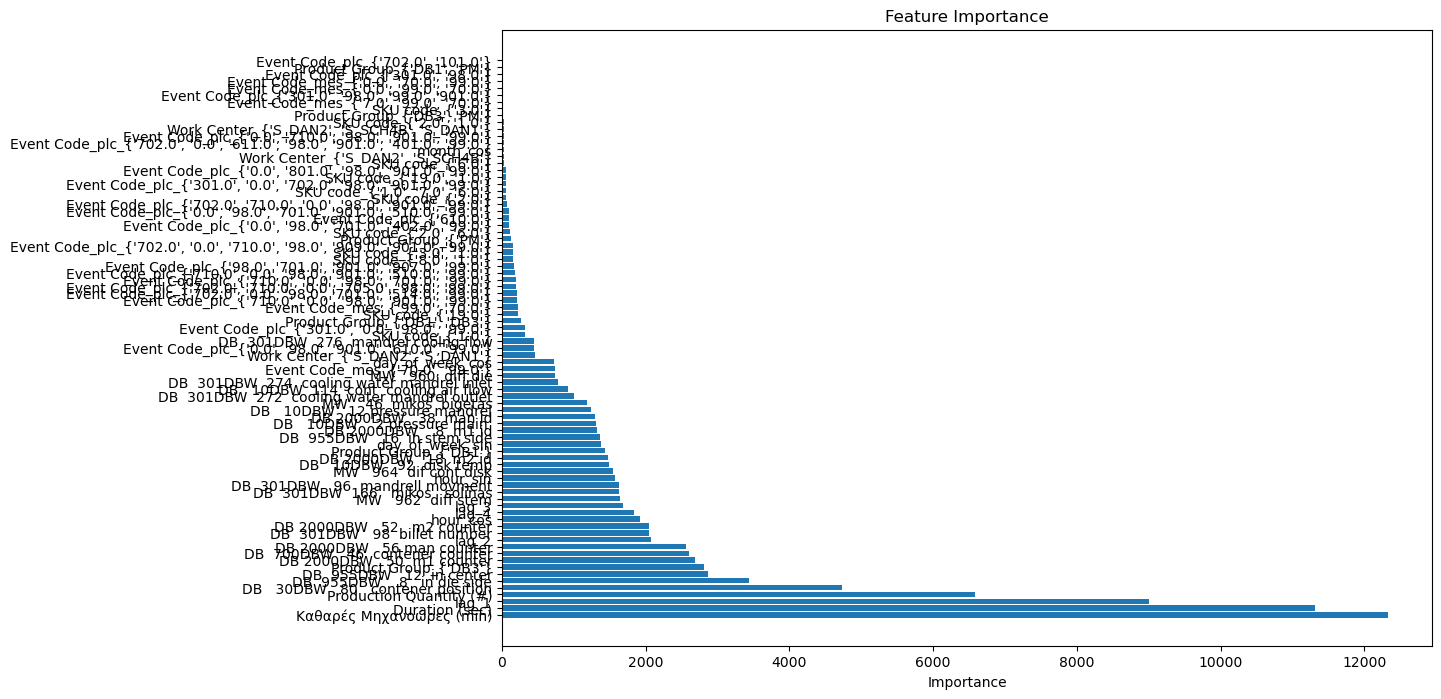

In [33]:
# Assuming 'model' is your trained XGBoost model
# Get feature importances
importance = model.get_score(importance_type='weight')

# Convert the importance dictionary to a DataFrame for easier plotting
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

<Figure size 1200x800 with 0 Axes>

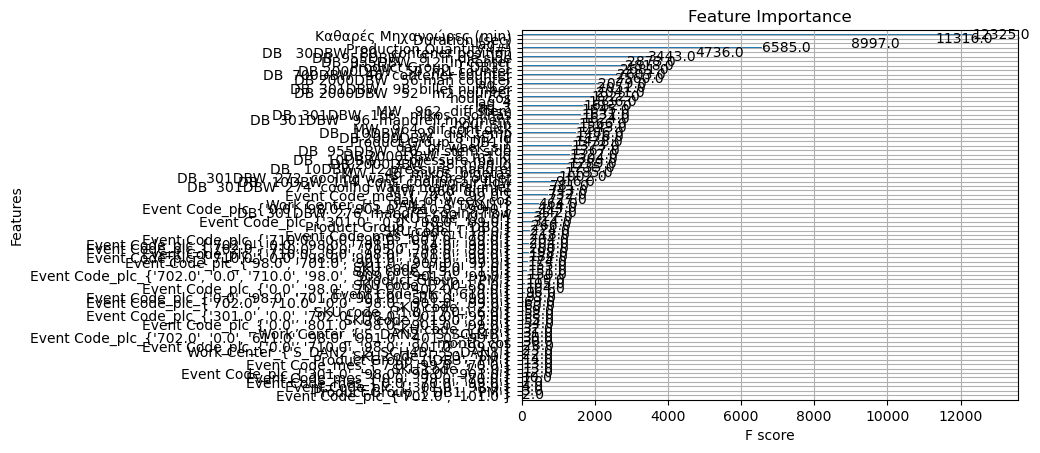

In [35]:
# Plot feature importance
from xgboost import plot_importance

plt.figure(figsize=(12, 8))
plot_importance(model, importance_type='weight')  # You can also use 'gain' or 'cover'
plt.title('Feature Importance')
plt.show()


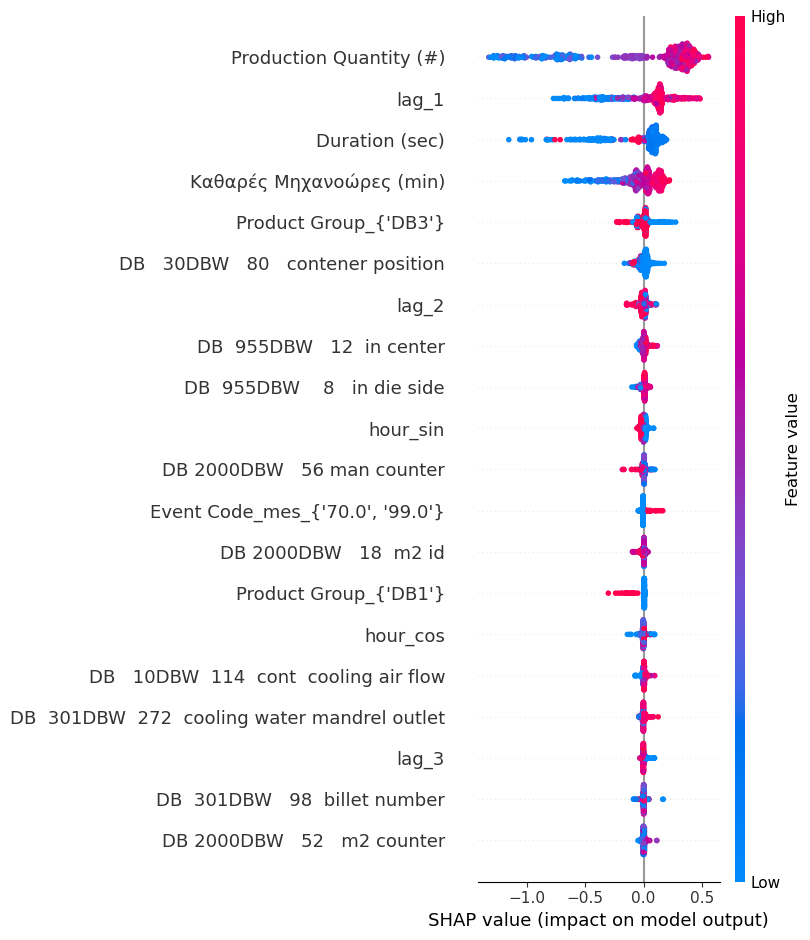

In [34]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_combined)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_combined)